# Advection in JAX

In [1]:
import jax
import jax.lax as lax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import Array, random, jit
from jax.typing import ArrayLike

For a given advected quantity $q(x, t)$ the advection equation can be written as.
$$\frac{\partial q(x, t)}{\partial t} + A \frac{\partial q(x, t)}{\partial x} = 0$$
We then discretize it using first order forward approximations in time and space.
$$\frac{q_i^{n+1} - q_i^n}{\Delta t} + A \frac{q_{i+1}^n - q_{i-1}^n}{2\Delta x} = 0$$
This gives us an expression for $q_i^{n+1}$.
$$q_i^{n+1} = q_i^n - \frac{1}{2} \frac{\Delta t \cdot A}{\Delta x} \left(q_{i+1}^n - q_{i-1}^n\right)$$

In [ ]:
def advection(u=1.0, dx=1.0, dt=1.0, Lx=100, Lt=100) -> Array:
    Nx = int(Lx / dx)
    Nt = int(Lt / dt)
    save_interval = int(1 / dt)

    phi0 = jnp.exp(-(jnp.linspace(0, Lx, Nx) - (Lx/2))** 2 / 10.0)
    phi = jnp.zeros((Nt, Nx)).at[0].set(phi0)

    @jit
    def advection_loop(
        phi: ArrayLike, u: float, dx: float, dt: float
    ) -> Array:

        def loop(t_idx: int, phi: ArrayLike):
            phi_old = phi[t_idx - 1]
            phi_new = phi_old - dt * u / (dx) * (jnp.roll(phi_old, 0) - jnp.roll(phi_old, 1))
            phi = phi.at[t_idx].set(phi_new)

            return phi

        return lax.fori_loop(1, Nt, loop, phi)

    return advection_loop(phi, u, dx, dt)

with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):
    phi = advection(Lx=100, dx=0.01, dt=0.01, u=0.5).block_until_ready()

2024-04-05 11:13:50.582621: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Open URL in browser: https://ui.perfetto.dev/#!/?url=http://127.0.0.1:9001/perfetto_trace.json.gz


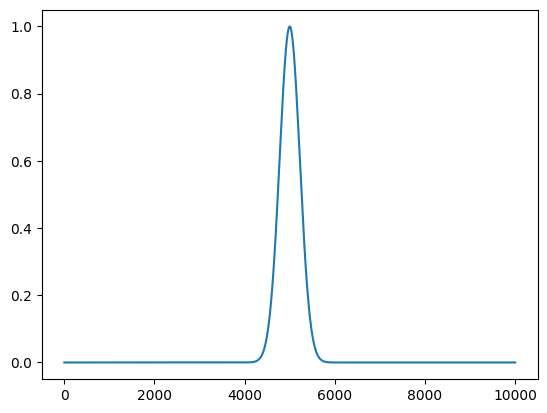

In [8]:
plt.plot(phi[0])

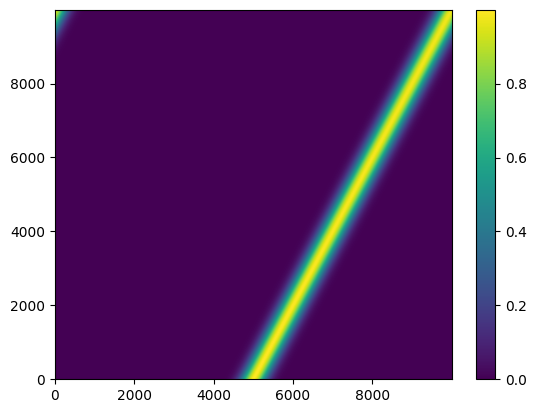

In [9]:
plt.imshow(phi, aspect="auto",origin="lower")
plt.colorbar()

In [ ]:
plt.plot(phi[-1])